In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import re

import patsy

from statsmodels.api import OLS, MNLogit, Logit
from scipy.stats import ttest_ind, entropy

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer, recall_score, f1_score

from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from joblib import Parallel, delayed


from twokenize_wrapper import tokenize

sns.set_context('poster')
sns.set_style('ticks')

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display

In [2]:
DATASET_LABELS={
    "clarin": "Clarin", 
    "semeval": "SemEval", 
    "airline": "Airline", 
    "gop_debate": "GOP", 
    "hcr": "Healthcare", 
    "obama_debate": "Obama", 
}

df_meta = pd.read_csv("./data/joined_data_all.txt", sep="\t",
                      parse_dates=["created_at", "u_created_at"])
df_meta["opinionated"] = df_meta.label != "neutral"
df_meta["followers_friends"] = (df_meta[u'u_followers'] + 1)/(df_meta[u'u_friends'] + 1)
df_meta["statuses_followers"] = (df_meta[u'u_statuses'] + 1)/(df_meta[u'u_followers'] + 1)
df_meta["statuses_friends"] = (df_meta[u'u_statuses'] + 1)/(df_meta[u'u_friends'] + 1)
df_meta["user_age"] = (df_meta.created_at - df_meta.u_created_at).dt.round("D").apply(lambda x: (x.days))
df_meta.columns, df_meta.shape

(Index([u'tid', u'favorites', u'is_quote', u'is_reply', u'retweets',
        u'u_created_at', u'u_followers', u'u_friends', u'u_lists',
        u'u_statuses', u'u_verified', u'u_location', u'u_has_url',
        u'n_hashtags', u'n_symbols', u'n_urls', u'n_mentions', u'created_at',
        u'dataset', u'datasplit', u'language', u'label', u'opinionated',
        u'followers_friends', u'statuses_followers', u'statuses_friends',
        u'user_age'],
       dtype='object'), (131605, 27))

In [3]:
df_text = pd.read_json("./data/joined_data_all.text.json", orient='split')
df_text.columns, df_text.shape

(Index([u'tid', u'text'], dtype='object'), (131605, 2))

In [4]:
df_meta.dataset = df_meta.dataset.apply(lambda x: DATASET_LABELS[x])
df_meta.dataset.value_counts()

Clarin        61667
SemEval       42911
Airline       12258
GOP           10030
Obama          2608
Healthcare     2131
Name: dataset, dtype: int64

In [5]:
df_text.head()

,tid,text
0,936466992,Here we go. #tweetdebate
1,936467521,#tweetdebate letting mom/dad follow debate on ...
2,936467712,what is an appropriately bi-partisan food to b...
3,936468396,@current one minute to get your stuff together...
4,936468736,@current I've got the live stream going #curre...


In [6]:
df_text.shape

(131605, 2)

In [7]:
df = df_meta.merge(df_text, on="tid", how="left")
df.columns

Index([               u'tid',          u'favorites',           u'is_quote',
                 u'is_reply',           u'retweets',       u'u_created_at',
              u'u_followers',          u'u_friends',            u'u_lists',
               u'u_statuses',         u'u_verified',         u'u_location',
                u'u_has_url',         u'n_hashtags',          u'n_symbols',
                   u'n_urls',         u'n_mentions',         u'created_at',
                  u'dataset',          u'datasplit',           u'language',
                    u'label',        u'opinionated',  u'followers_friends',
       u'statuses_followers',   u'statuses_friends',           u'user_age',
                     u'text'],
      dtype='object')

In [8]:
df_meta.shape, df_text.shape, df.shape

((131605, 27), (131605, 2), (131605, 28))

In [9]:
df_meta.tid.unique().shape

(131605,)

In [10]:
df.text.head()

0                             Here we go. #tweetdebate
1    #tweetdebate letting mom/dad follow debate on ...
2    what is an appropriately bi-partisan food to b...
3    @current one minute to get your stuff together...
4    @current I've got the live stream going #curre...
Name: text, dtype: object

In [11]:
df_t = df.text.head()
df_t

0                             Here we go. #tweetdebate
1    #tweetdebate letting mom/dad follow debate on ...
2    what is an appropriately bi-partisan food to b...
3    @current one minute to get your stuff together...
4    @current I've got the live stream going #curre...
Name: text, dtype: object

In [12]:
print tokenize(df_t.values[0])

[u'Here', u'we', u'go', u'.', u'#tweetdebate']


In [13]:
INVALID_STARTS=set(["@", "#", "http://"])
def valid_token(token):
    for start in INVALID_STARTS:
        if token.startswith(start):
            return False
    if token.isdigit():
        return False
    return True

def process_tweets(text):
    tokens = tokenize(text.lower())
    tokens = filter(valid_token, tokens)
    return tokens
    

In [14]:
df.language.value_counts()

english    128625
arabic       2980
Name: language, dtype: int64

## Prepare training data

In [15]:
for dataset in df.dataset.unique():
    if dataset == "SemEval":
        print dataset, "skipping"
    df_t = df[(df.dataset == dataset) & (df.language == "english")]
    df_train, df_test = train_test_split(
        df_t, test_size=0.2, random_state=1337, stratify=df_t.label)
    df_train, df_dev = train_test_split(
        df_train, test_size=0.1, random_state=1337, stratify=df_train.label)
    df.ix[df_train.index, "datasplit"] = "train"
    df.ix[df_dev.index, "datasplit"] = "dev"
    df.ix[df_test.index, "datasplit"] = "test"
    print dataset, df_train.shape, df_dev.shape, df_test.shape

Obama (1877, 28) (209, 28) (522, 28)
Healthcare (1533, 28) (171, 28) (427, 28)
SemEval skipping
SemEval (28749, 28) (3195, 28) (7987, 28)
Clarin (44399, 28) (4934, 28) (12334, 28)
Airline (8825, 28) (981, 28) (2452, 28)
GOP (7221, 28) (803, 28) (2006, 28)


In [16]:
df[(df.language == "english")].datasplit.value_counts()

train    92604
test     25728
dev      10293
Name: datasplit, dtype: int64

In [17]:
df[(df.language == "english")].pivot_table(index="dataset", columns="datasplit", values="tid", aggfunc=len)

datasplit,dev,test,train
dataset,,,
Airline,981,2452,8825
Clarin,4934,12334,44399
GOP,803,2006,7221
Healthcare,171,427,1533
Obama,209,522,1877
SemEval,3195,7987,28749


In [18]:
df[(df.language == "english")].pivot_table(index="dataset", columns=["datasplit", "label"], values="tid", aggfunc=len)

datasplit       dev                      test                     train  \
label      negative neutral positive negative neutral positive negative   
dataset                                                                   
Airline         613     205      163     1532     512      408     5515   
Clarin         1276    2158     1500     3191    5394     3749    11485   
GOP             471     202      130     1175     505      326     4230   
Healthcare       93      42       36      232     106       89      834   
Obama            80      79       50      199     197      126      715   
SemEval         479    1448     1268     1198    3620     3169     4313   

datasplit                    
label      neutral positive  
dataset                      
Airline       1843     1467  
Clarin       19418    13496  
GOP           1818     1173  
Healthcare     378      321  
Obama          707      455  
SemEval      13031    11405

## Train models

#### Custom scoring function

In [19]:
def custom_prf_scorer(model, X, y_true):
    epsilon = 1./y_true.shape[0]
    y_pred = model.predict(X)
    scores = precision_recall_fscore_support(y_true, y_pred, average="macro")
    y_pred_dist = pd.Series(model.predict_proba(X).mean(axis=0),
                            index=model.classes_, name="prediction")
    y_true_dist = (y_true.value_counts() * 1. / y_true.shape[0])[model.classes_]
    #print pd.concat([y_pred_dist, y_true_dist], axis=1)
    #print model.classes_
    kld_pcc = entropy(y_true_dist.values + epsilon, y_pred_dist.values + epsilon)
    
    y_pred_dist = (pd.Series(y_pred).value_counts() * 1. / y_true.shape[0])[model.classes_].fillna(0.)
    kld_cc = entropy(y_true_dist.values + epsilon, y_pred_dist.values + epsilon)
    
    acc = ((y_pred == y_true)*1.).mean()
    
    return scores + (kld_pcc, kld_cc, acc)

scoring = custom_prf_scorer

In [20]:
class RunModels(object):
    def __init__(self, df_t, 
                 model_meta_features,
                 model_text_features,
                 scoring,
                 dataset,
                 joint_transform=None
                ):
        self.model_meta_features = model_meta_features
        self.model_text_features = model_text_features
        
        self.scores = []
        self.models = []
        
        self.scoring = scoring
        self.dataset = dataset
        
        self.df_train = df_t[(df_t.datasplit == "train")]
        self.df_dev = df_t[(df_t.datasplit == "dev")]
        self.df_test = df_t[(df_t.datasplit == "test")]
        
        print "Prepared datasets"
        
    def get_joint_X(self, df_sample):
        X = pd.DataFrame(
            data=np.hstack([self.meta_model.predict_log_proba(df_sample.copy()),
                            self.text_model.predict_log_proba(df_sample.copy())]),
            columns=(self.meta_cols + self.text_cols)
        )
        return X
            
    def model_scoring(self, model, model_label):
        self.models.append((self.dataset, model_label, model))
        
        for df_sample, sample_label in zip(
            [self.df_train, self.df_dev, self.df_test],
            ["train", "dev", "test"]):
            X = df_sample.copy()
            y_true = df_sample.label.copy()
            
            if model_label == "joint":
                X = self.get_joint_X(df_sample)
            self.scores.append(
                (self.dataset, model_label, sample_label,)
                + self.scoring(model, X=X, y_true=y_true)
            )
        
    def train_text_model(self):
        model_label = "text"
        self.text_model = Pipeline([
            ('features', DataFrameMapper(self.model_text_features, sparse=True)),
            ('model', LogisticRegression(multi_class="multinomial", solver="lbfgs"))
        ])

        self.text_model.fit(X=self.df_train.copy(),
                            y=self.df_train.label)
        self.model_scoring(self.text_model, model_label)
        self.text_cols = ["text_%s" % k for k in self.text_model.classes_]
        print "Done text model"
    
    def train_meta_model(self):
        model_label = "meta"
        self.meta_model = Pipeline([
                ('features', DataFrameMapper(self.model_meta_features, sparse=True)),
                ('model', LogisticRegression(multi_class="multinomial", solver="lbfgs"))
            ])
        self.meta_model.fit(X=self.df_train.copy(),
                            y=self.df_train.label)
        self.model_scoring(self.meta_model, model_label)
        self.meta_cols = ["meta_%s" % k for k in self.meta_model.classes_]
        print "Done meta model"
        
    
    def train_joint_model(self):
        model_label = "joint"
        df_predicted = self.get_joint_X(self.df_train)
        self.joint_model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
        self.joint_model.fit(X=df_predicted.copy(), y=self.df_train.label)
        self.model_scoring(self.joint_model, model_label)
        self.joint_cols = df_predicted.columns
        print "Done joint model"
        
        
    def train_all_models(self):
        self.train_text_model()
        self.train_meta_model()
        self.train_joint_model()

In [21]:
def get_scores_df(scores):
    df_scores = pd.DataFrame(
        sum(scores, []),
        columns=["dataset", "model", "datasplit",
                 "precision", "recall", "f1", 
                 "support", "kld_pcc", "kld_cc", "accuracy"]
    )
    return df_scores


def get_models_df(models):
    df_models = pd.DataFrame(
        sum(models, []),
        columns=["dataset", "model", "config"])
    return df_models.set_index(["dataset", "model"])["config"].to_dict()

def plot_scores(df_scores, y="f1", label="F1 Score"):
    g = sns.factorplot(x="model", y=y,
                   hue="datasplit",
                   #hue_order=["text", "joint"],
                   col="dataset",
                    order = ["meta", "text", "joint"],
                   col_wrap=3,
                    sharey=False,
                   col_order=sorted(df.dataset.unique()),
                   palette=sns.color_palette(["k", "r", "b"]),
                   lw=0.5, ms=2,
        data=df_scores#.query("datasplit != 'train'")
    )
    #model != 'meta' and 

    g.set_axis_labels("Model", label).set_titles("{col_name}")
    return g


In [22]:
%%time

feature_map = {
        "text": [('text', [#TfidfVectorizer(tokenizer=process_tweets),
            TfidfVectorizer(tokenizer=process_tweets,
                                           stop_words='english',
                                           ngram_range=(1,2),
                                           min_df=10,
                                          )
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['u_statuses', 'u_friends', 'u_followers'], StandardScaler()),
            (['u_statuses_2', 'u_friends_2', 'u_followers_2'], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
        ]
    }


model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

def run_experiment(df_processed, dataset):
    df_t = df_processed
    df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
        }).assign(**{
            "u_statuses_2": lambda x: (x["u_statuses"]**2),
            "u_followers_2": lambda x: (x["u_followers"]**2),
            "u_friends_2": lambda x: (x["u_friends"]**2),
        })

    experiment = RunModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset, 
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models, dataset, experiment.joint_cols
    
scores, models, datasets, joint_cols = zip(
    *Parallel(n_jobs=6, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in df.dataset.unique()
    )
)

Dataset: Obama
Prepared datasets
(2608, 28)
Dataset: Healthcare
Prepared datasets
(2131, 28)
Dataset: SemEval
Prepared datasets
(39931, 28)
Dataset: Clarin
Prepared datasets
(61667, 28)
Dataset: Airline
(12258, 28)
Prepared datasets
Dataset: GOP
(10030, 28)
Prepared datasets
Done text model
Done meta model
Done text model
Done meta model
Done joint model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:    5.4s remaining:   -0.8s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   20.7s remaining:   -3.0s


Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   24.6s remaining:   -3.5s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.4min remaining:  -11.6s


Done joint model
CPU times: user 2.5 s, sys: 408 ms, total: 2.9 s
Wall time: 1min 28s


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.5min remaining:  -12.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.5min finished


In [23]:
df_scores = get_scores_df(scores)
df_scores.query("datasplit == 'test'")

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
2,Obama,text,test,0.590407,0.544692,0.556744,None,4.768462e-04,0.025879,0.557471
5,Obama,meta,test,0.352900,0.352568,0.307293,None,4.722683e-05,0.591711,0.400383
8,Obama,joint,test,0.592504,0.571801,0.579069,None,1.119715e-03,0.007736,0.578544
11,Healthcare,text,test,0.579563,0.480240,0.491688,None,6.457649e-04,0.123046,0.604215
14,Healthcare,meta,test,0.371133,0.388961,0.345328,None,1.840713e-04,0.651550,0.564403
17,Healthcare,joint,test,0.543818,0.501112,0.512009,None,1.435484e-03,0.034592,0.587822
20,SemEval,text,test,0.631357,0.571440,0.585760,None,2.035590e-05,0.033203,0.646926
23,SemEval,meta,test,0.310184,0.361763,0.329253,None,8.402840e-07,0.950126,0.469388
26,SemEval,joint,test,0.617214,0.599094,0.606429,None,5.254905e-05,0.003801,0.648429
29,Clarin,text,test,0.635492,0.609632,0.617881,None,4.876945e-05,0.015194,0.631182


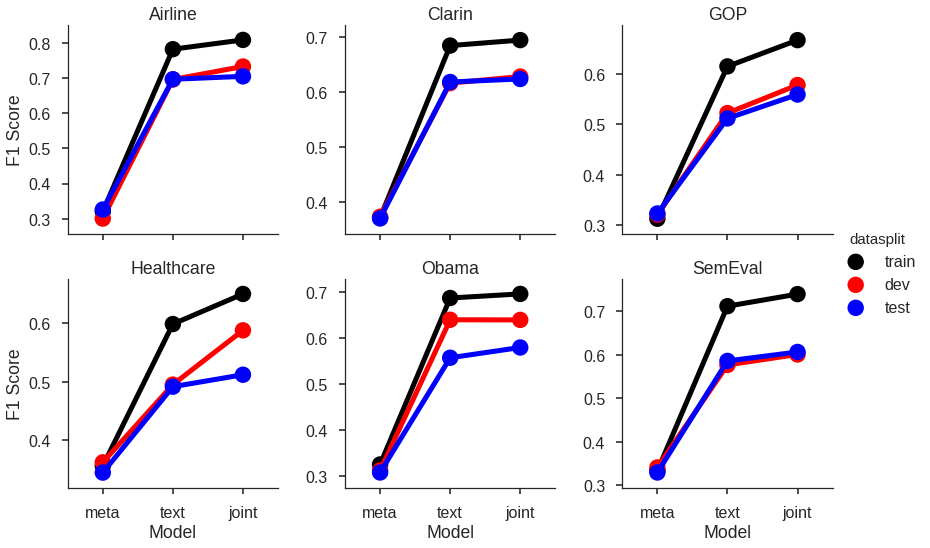

In [24]:
plot_scores(df_scores, y="f1", label="F1 Score")

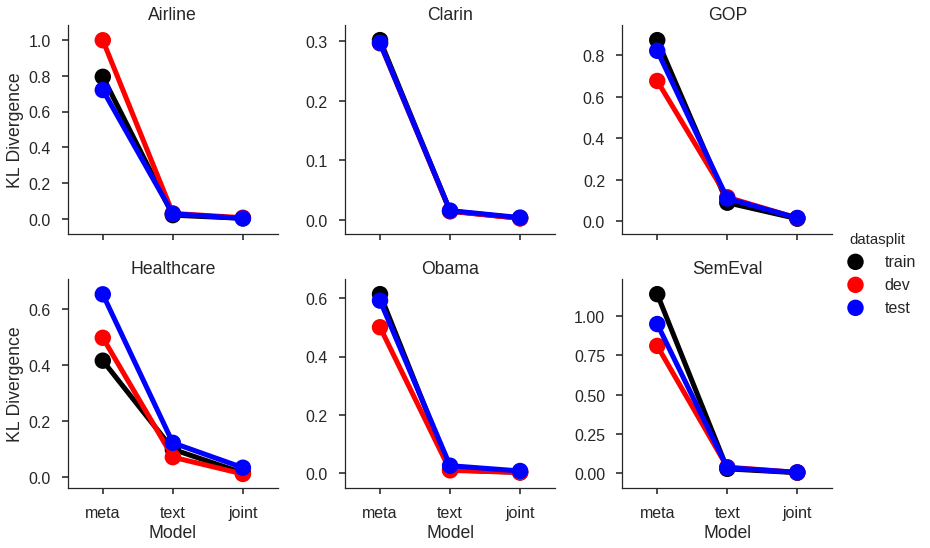

In [25]:
plot_scores(df_scores, y="kld_cc", label="KL Divergence")

### Plot coef heatmap for SemEval

In [26]:
df_models = get_models_df(models)
clf = df_models[("SemEval", "joint")]
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

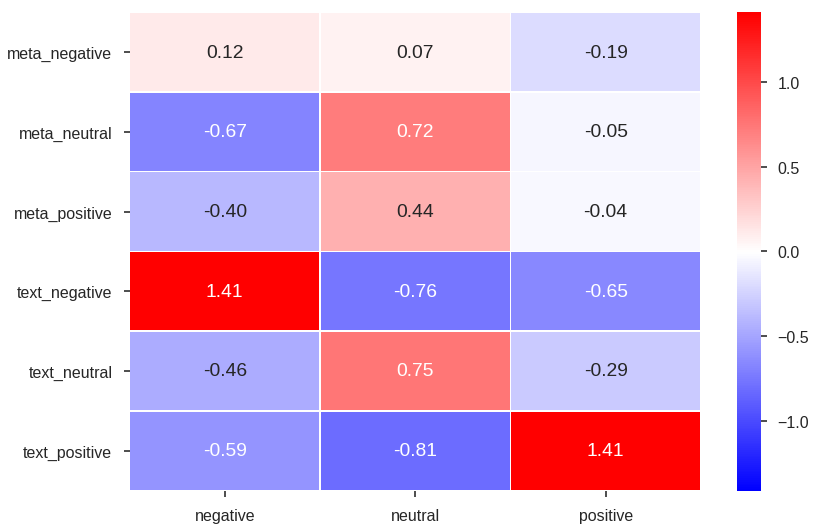

In [27]:
sns.heatmap(pd.DataFrame(clf.coef_,
                         columns=dict(zip(datasets, joint_cols))["SemEval"],
                         index=clf.classes_).T,
           cmap="bwr", annot=True, fmt=".2f", linewidths=.5)

## Joint model with ratio features

In [28]:
%%time

feature_map = {
        "text": [('text', [TfidfVectorizer(tokenizer=process_tweets),
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['statuses_followers', 'followers_friends', ], StandardScaler()),
            (['u_statuses', 'u_statuses_2', ], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
        ]
    }



model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

def run_experiment(df_processed, dataset):
    df_t = df_processed
    df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
        "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
        "statuses_followers": lambda x: np.log10(x["statuses_followers"]),
        "followers_friends": lambda x: np.log10(x["followers_friends"]),
        "n_urls": lambda x: np.log10(x["n_urls"] + 1),
        "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
        "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
    }).assign(**{
        "u_statuses_2": lambda x: (x["u_statuses"]**2),
    })

    experiment = RunModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset, 
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models
    
scores, models = zip(
    *Parallel(n_jobs=6, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in df.dataset.unique()
    )
)

Dataset: Obama
Prepared datasets
(2608, 28)
Dataset: Healthcare
Prepared datasets
(2131, 28)
Dataset: SemEval
(39931, 28)
Prepared datasets
Dataset: Clarin
Prepared datasets
(61667, 28)
Dataset: Airline
Prepared datasets
(12258, 28)
Dataset: GOP
(10030, 28)
Prepared datasets
Done text model
Done meta model
Done text model
Done meta model
Done joint model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:    5.3s remaining:   -0.8s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   19.6s remaining:   -2.8s


Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   23.1s remaining:   -3.3s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.3min remaining:  -10.8s


Done joint model
CPU times: user 2.34 s, sys: 468 ms, total: 2.81 s
Wall time: 1min 23s


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.4min remaining:  -11.9s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.4min finished


In [29]:
df_scores = get_scores_df(scores)
df_scores.query("datasplit == 'test'")

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
2,Obama,text,test,0.647716,0.597071,0.608944,None,2.577431e-04,0.030049,0.614943
5,Obama,meta,test,0.402682,0.357086,0.319956,None,4.439220e-05,0.411755,0.402299
8,Obama,joint,test,0.626472,0.616534,0.620537,None,9.492910e-04,0.002480,0.620690
11,Healthcare,text,test,0.712503,0.495101,0.510473,None,6.796622e-04,0.233397,0.641686
14,Healthcare,meta,test,0.483280,0.390999,0.350296,None,1.863720e-04,0.600735,0.566745
17,Healthcare,joint,test,0.596128,0.575701,0.582928,None,2.534399e-03,0.008387,0.639344
20,SemEval,text,test,0.641040,0.579747,0.594688,None,5.532440e-06,0.031774,0.654564
23,SemEval,meta,test,0.310266,0.361881,0.329391,None,1.286828e-06,0.949908,0.469513
26,SemEval,joint,test,0.623859,0.612821,0.617675,None,1.998051e-05,0.001293,0.655190
29,Clarin,text,test,0.645024,0.621608,0.629493,None,1.582741e-04,0.012315,0.640830


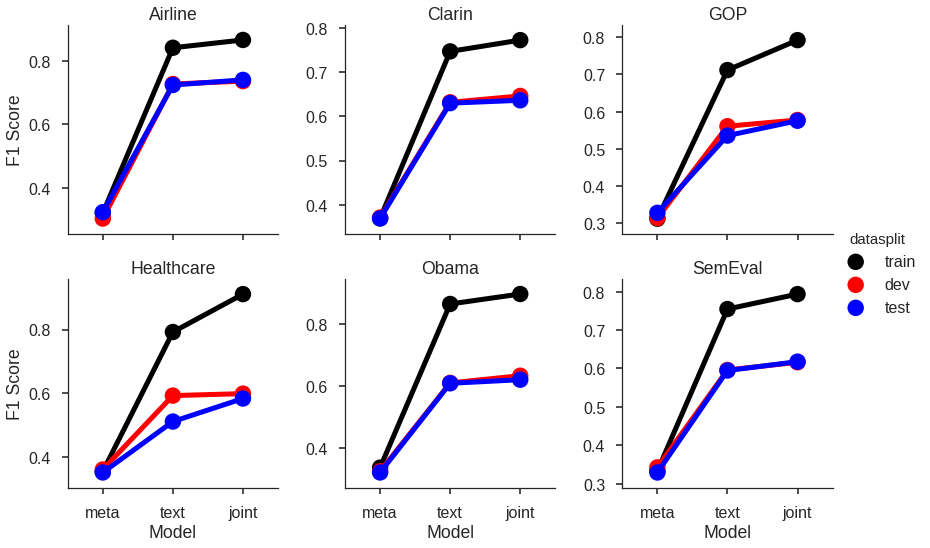

In [30]:
plot_scores(df_scores, y="f1", label="F1 Score")

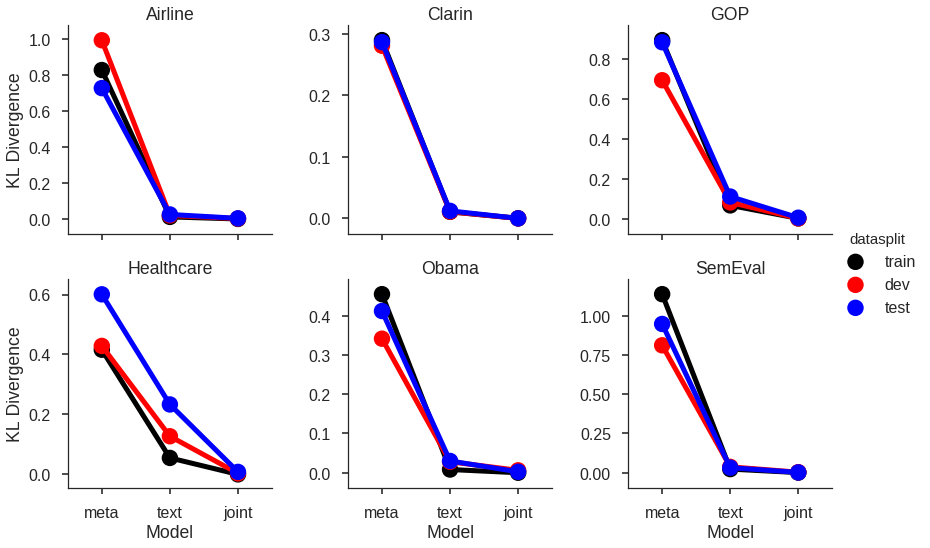

In [31]:
plot_scores(df_scores, y="kld_cc", label="KL Divergence")

## Joint model with interaction

In [32]:
%%time

feature_map = {
        "text": [('text', [TfidfVectorizer(tokenizer=process_tweets),
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['statuses_followers', 'statuses_friends',
              'statuses_followers_2', 'statuses_friends_2',
             ], StandardScaler()),
            (['u_statuses', 'u_statuses_2', ], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
        ]
    }


model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

class InteractionJointModels(RunModels):
    def get_joint_X(self, df_sample):
        X = pd.DataFrame(
            data=np.hstack([self.meta_model.predict_log_proba(df_sample.copy()),
                            self.text_model.predict_log_proba(df_sample.copy())]),
            columns=(self.meta_cols + self.text_cols)
        )
        joint_formula = "(%s)*(%s)" % ("+".join(self.meta_cols), "+".join(self.text_cols))
        X = patsy.dmatrix(joint_formula, X, return_type="dataframe")
        return X


def run_experiment(df_processed, dataset):
    df_t = df_processed
    df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "statuses_followers": lambda x: np.log10(x["statuses_followers"]),
            "statuses_friends": lambda x: np.log10(x["statuses_friends"]),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
        }).assign(**{
            "u_statuses_2": lambda x: (x["u_statuses"]**2),
            "statuses_followers_2": lambda x: (x["statuses_followers"]**2),
            "statuses_friends_2": lambda x: (x["statuses_friends"]**2),
        })

    experiment = InteractionJointModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset,
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models, dataset, experiment.joint_cols
    
scores, models, datasets, joint_cols = zip(
    *Parallel(n_jobs=6, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in df.dataset.unique()
    )
)

Dataset: Obama
Prepared datasets
(2608, 28)
Dataset: Healthcare
Prepared datasets
(2131, 28)
Dataset: SemEval
Prepared datasets
(39931, 28)
Dataset: Clarin
Prepared datasets
(61667, 28)
Dataset: Airline
Prepared datasets
(12258, 28)
Dataset: GOP
(10030, 28)
Prepared datasets
Done text model
Done meta model
Done text model
Done meta model
Done joint model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:    5.3s remaining:   -0.8s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   19.6s remaining:   -2.8s


Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   23.0s remaining:   -3.3s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.3min remaining:  -10.8s


Done joint model
CPU times: user 2.18 s, sys: 432 ms, total: 2.61 s
Wall time: 1min 24s


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.4min remaining:  -12.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.4min finished


In [33]:
df_scores = get_scores_df(scores)
df_scores.query("datasplit == 'test'")

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
2,Obama,text,test,0.647716,0.597071,0.608944,None,0.000258,0.030049,0.614943
5,Obama,meta,test,0.404144,0.356664,0.328768,None,0.000049,0.300331,0.398467
8,Obama,joint,test,0.628083,0.618209,0.622142,None,0.000978,0.002613,0.622605
11,Healthcare,text,test,0.712503,0.495101,0.510473,None,0.000680,0.233397,0.641686
14,Healthcare,meta,test,0.475048,0.394685,0.356270,None,0.000167,0.571516,0.564403
17,Healthcare,joint,test,0.581366,0.565101,0.570435,None,0.002989,0.007853,0.627635
20,SemEval,text,test,0.641040,0.579747,0.594688,None,0.000006,0.031774,0.654564
23,SemEval,meta,test,0.309811,0.361591,0.329525,None,0.000002,0.947230,0.468762
26,SemEval,joint,test,0.623773,0.613763,0.618217,None,0.000019,0.001074,0.655440
29,Clarin,text,test,0.645024,0.621608,0.629493,None,0.000158,0.012315,0.640830


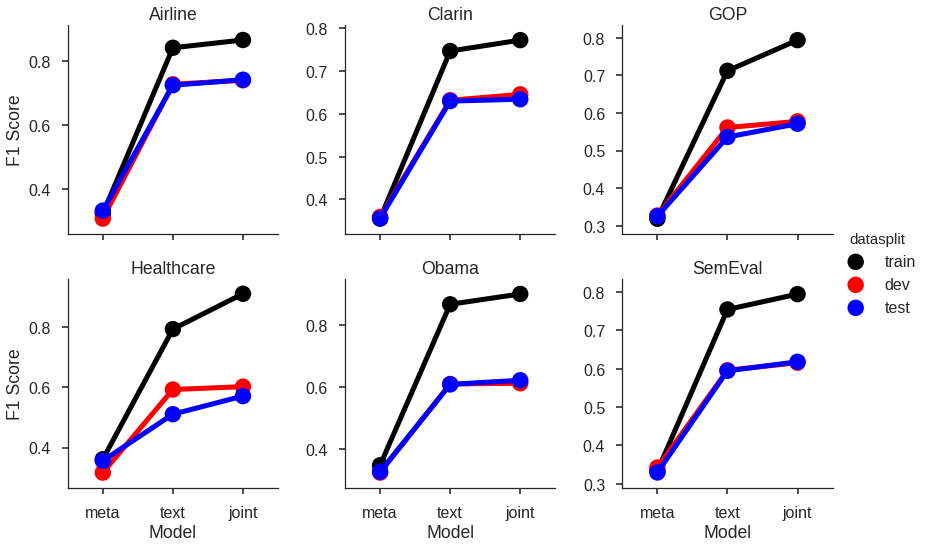

In [34]:
plot_scores(df_scores, y="f1", label="F1 Score")

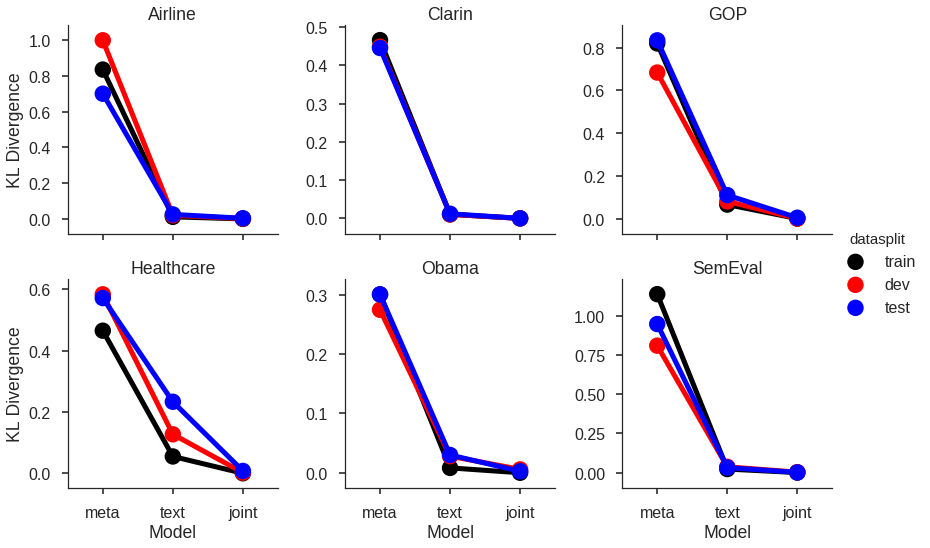

In [35]:
plot_scores(df_scores, y="kld_cc", label="KL Divergence")

### Plot coef heatmap for SemEval

In [36]:
df_models = get_models_df(models)
clf = df_models[("SemEval", "joint")]
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

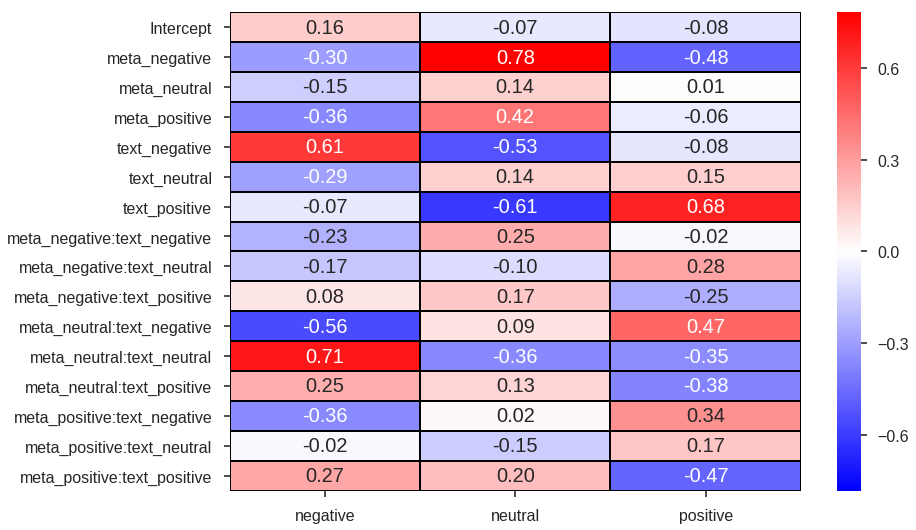

In [37]:
sns.heatmap(pd.DataFrame(clf.coef_,
                         columns=dict(zip(datasets, joint_cols))["SemEval"],
                         index=clf.classes_).T,
           cmap="bwr", annot=True, fmt=".2f",
            linewidths=1,
            linecolor="k",
            #square=True,
            annot_kws={
               "fontsize": 20
           })

## Direct concat features in joint model

In [38]:
%%time

feature_map = {
        "text": [('text', [#TfidfVectorizer(tokenizer=process_tweets),
            TfidfVectorizer(tokenizer=process_tweets,
                                           stop_words='english',
                                           ngram_range=(1,2),
                                           min_df=10,
                                          )
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['u_statuses', 'u_friends', 'u_followers'], StandardScaler()),
            (['u_statuses_2', 'u_friends_2', 'u_followers_2'], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
        ]
    }


model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

class ConcatJointModels(RunModels):
    def train_joint_model(self):
        model_label = "joint"
        self.joint_model = Pipeline([
                ('features', DataFrameMapper(
                    self.model_meta_features + self.model_text_features,
                    sparse=True)),
                ('model', LogisticRegression(multi_class="multinomial", solver="lbfgs"))
            ])
        self.joint_model.fit(X=self.df_train.copy(),
                            y=self.df_train.label)
        self.model_scoring(self.joint_model, model_label)
        print "Done joint model"
        
    def get_joint_X(self, df_sample):
        return df_sample

def run_experiment(df_processed, dataset):
    df_t = df_processed
    df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
        }).assign(**{
            "u_statuses_2": lambda x: (x["u_statuses"]**2),
            "u_followers_2": lambda x: (x["u_followers"]**2),
            "u_friends_2": lambda x: (x["u_friends"]**2),
        })
    
    experiment = ConcatJointModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset,
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models
    
scores, models = zip(
    *Parallel(n_jobs=6, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in df.dataset.unique()
    )
)

Dataset: Obama
Prepared datasets
(2608, 28)
Dataset: Healthcare
Prepared datasets
(2131, 28)
Dataset: SemEval
Prepared datasets
(39931, 28)
Dataset: Clarin
Prepared datasets
(61667, 28)
Dataset: Airline
Prepared datasets
(12258, 28)
Dataset: GOP
(10030, 28)
Prepared datasets
Done text model
Done meta model
Done text model
Done meta model
Done joint model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:    6.8s remaining:   -1.0s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   26.6s remaining:   -3.8s


Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   31.8s remaining:   -4.5s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.8min remaining:  -15.8s


Done joint model
CPU times: user 2.6 s, sys: 476 ms, total: 3.08 s
Wall time: 1min 57s


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  2.0min remaining:  -16.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.0min finished


In [39]:
df_scores = get_scores_df(scores)
df_scores.query("datasplit == 'test'")

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
2,Obama,text,test,0.590407,0.544692,0.556744,None,4.768462e-04,0.025879,0.557471
5,Obama,meta,test,0.352900,0.352568,0.307293,None,4.722683e-05,0.591711,0.400383
8,Obama,joint,test,0.592319,0.551358,0.561955,None,5.786663e-04,0.024500,0.565134
11,Healthcare,text,test,0.579563,0.480240,0.491688,None,6.457649e-04,0.123046,0.604215
14,Healthcare,meta,test,0.371133,0.388961,0.345328,None,1.840713e-04,0.651550,0.564403
17,Healthcare,joint,test,0.551700,0.485282,0.498143,None,7.381718e-04,0.067222,0.590164
20,SemEval,text,test,0.631357,0.571440,0.585760,None,2.035590e-05,0.033203,0.646926
23,SemEval,meta,test,0.310184,0.361763,0.329253,None,8.402840e-07,0.950126,0.469388
26,SemEval,joint,test,0.636695,0.579017,0.593707,None,7.321719e-06,0.029741,0.651934
29,Clarin,text,test,0.635492,0.609632,0.617881,None,4.876945e-05,0.015194,0.631182


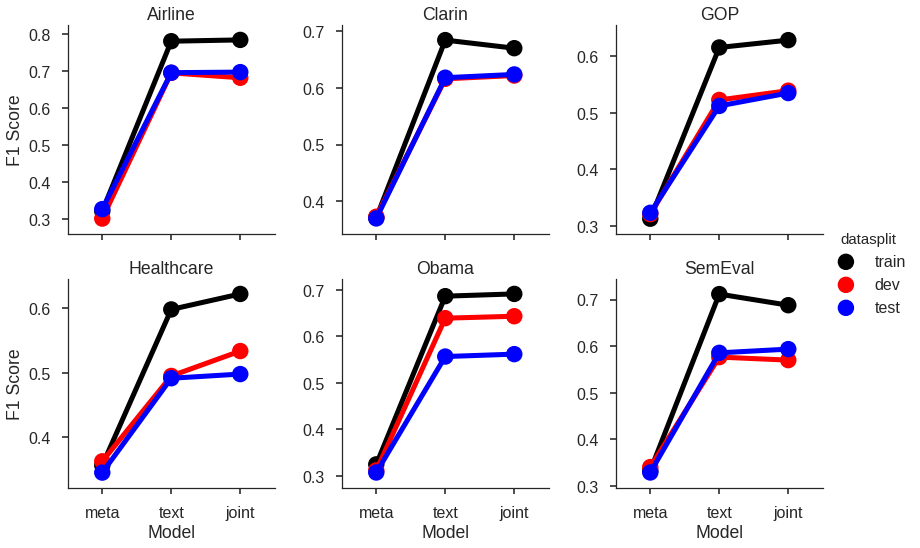

In [40]:
plot_scores(df_scores, y="f1", label="F1 Score")

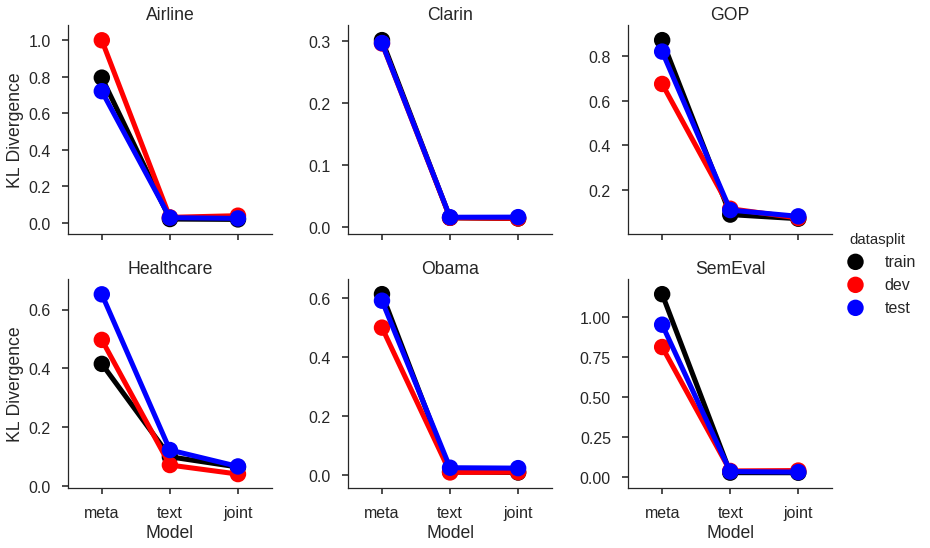

In [41]:
plot_scores(df_scores, y="kld_cc", label="KL Divergence")

## Final Joint model with interaction

In [96]:
%%time

feature_map = {
        "text": [('text', [TfidfVectorizer(tokenizer=process_tweets),
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['u_statuses', 'u_statuses_2',
              'u_followers', 'u_followers_2',
              'u_friends', 'u_friends_2',
              'user_age', 
             ], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
            (['is_reply', 'is_quote'], None)
        ]
    }


model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

class InteractionJointModels(RunModels):
    def get_joint_X(self, df_sample):
        X = pd.DataFrame(
            data=np.hstack([self.meta_model.predict_proba(df_sample.copy()),
                            self.text_model.predict_proba(df_sample.copy())]),
            columns=(self.meta_cols + self.text_cols)
        )
        joint_formula = "(%s)*(%s)" % ("+".join(self.meta_cols), "+".join(self.text_cols))
        X = patsy.dmatrix(joint_formula, X, return_type="dataframe")
        return X


def run_experiment(df_processed, dataset):
    df_t = df_processed
    df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "user_age": lambda x: np.log10(x["user_age"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
        }).assign(**{
            "u_statuses_2": lambda x: (x["u_statuses"]**2),
            "u_followers_2": lambda x: (x["u_followers"]**2),
            "u_friends_2": lambda x: (x["u_friends"]**2),
        })

    experiment = InteractionJointModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset,
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models, dataset, experiment.joint_cols
    
scores, models, datasets, joint_cols = zip(
    *Parallel(n_jobs=6, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in df.dataset.unique()
    )
)

Dataset: Obama
(2608, 28)
Prepared datasets
Dataset: Healthcare
(2131, 28)
Prepared datasets
Dataset: SemEval
(39931, 28)
Prepared datasets
Dataset: Clarin
(61667, 28)
Prepared datasets
Dataset: Airline
(12258, 28)
Prepared datasets
Dataset: GOP
(10030, 28)
Prepared datasets
Done text model
Done meta model
Done text model
Done meta model
Done joint model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:    5.8s remaining:   -0.8s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   20.5s remaining:   -2.9s


Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:   24.1s remaining:   -3.4s


Done text model
Done meta model
Done text model
Done meta model
Done joint model


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.3min remaining:  -11.0s


Done joint model
CPU times: user 2.8 s, sys: 636 ms, total: 3.44 s
Wall time: 1min 26s


[Parallel(n_jobs=6)]: Done   7 out of   6 | elapsed:  1.4min remaining:  -12.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.4min finished


In [97]:
df_scores = get_scores_df(scores)
df_scores.query("datasplit == 'test'")

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
2,Obama,text,test,0.647716,0.597071,0.608944,None,2.577431e-04,0.030049,0.614943
5,Obama,meta,test,0.370076,0.350584,0.320313,None,4.281170e-05,0.281970,0.392720
8,Obama,joint,test,0.631600,0.616302,0.622087,None,9.340243e-04,0.004496,0.622605
11,Healthcare,text,test,0.712503,0.495101,0.510473,None,6.796622e-04,0.233397,0.641686
14,Healthcare,meta,test,0.367582,0.393814,0.350784,None,1.247312e-04,0.716993,0.566745
17,Healthcare,joint,test,0.616077,0.582849,0.594710,None,2.340126e-03,0.014096,0.655738
20,SemEval,text,test,0.641040,0.579747,0.594688,None,5.532440e-06,0.031774,0.654564
23,SemEval,meta,test,0.310371,0.362183,0.329831,None,4.790522e-07,0.844699,0.469763
26,SemEval,joint,test,0.627261,0.604913,0.613610,None,7.457210e-05,0.005577,0.656066
29,Clarin,text,test,0.645024,0.621608,0.629493,None,1.582741e-04,0.012315,0.640830


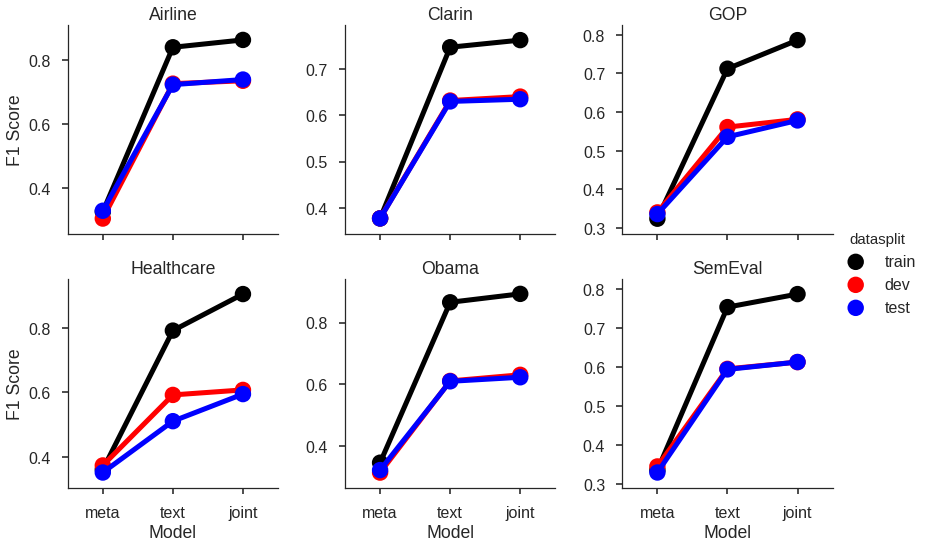

In [98]:
plot_scores(df_scores, y="f1", label="F1 Score")

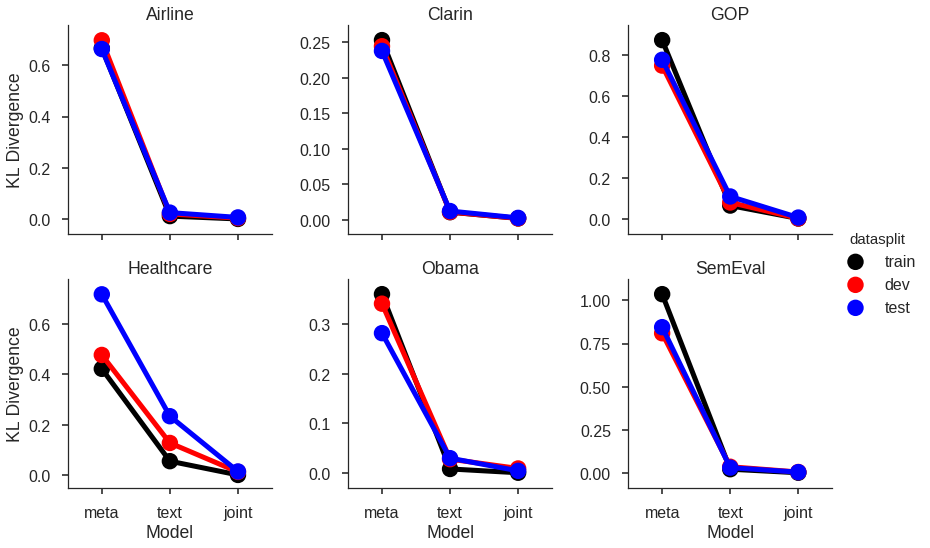

In [99]:
plot_scores(df_scores, y="kld_cc", label="KL Divergence")

### Plot coef heatmap for SemEval

In [100]:
df_models = get_models_df(models)
clf = df_models[("SemEval", "joint")]
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

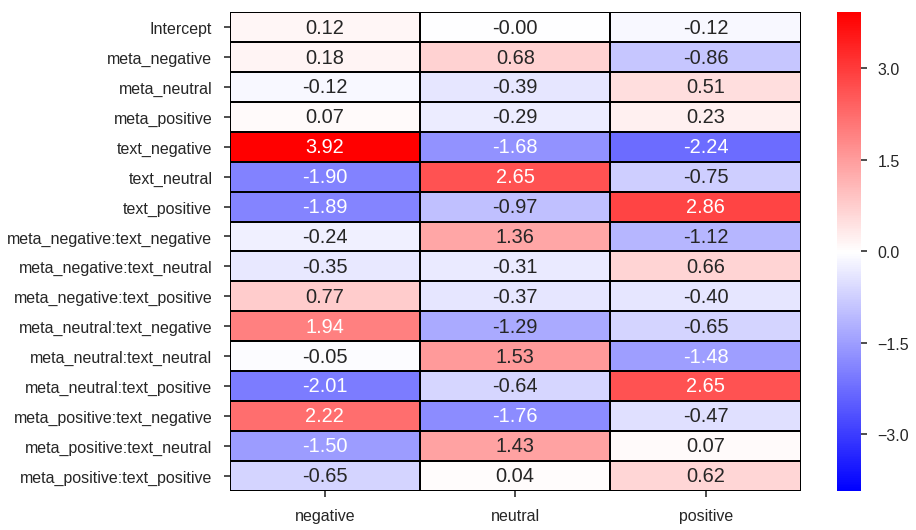

In [101]:
sns.heatmap(pd.DataFrame(clf.coef_,
                         columns=dict(zip(datasets, joint_cols))["SemEval"],
                         index=clf.classes_).T,
           cmap="bwr", annot=True, fmt=".2f",
            linewidths=1,
            linecolor="k",
            #square=True,
            annot_kws={
               "fontsize": 20
           })

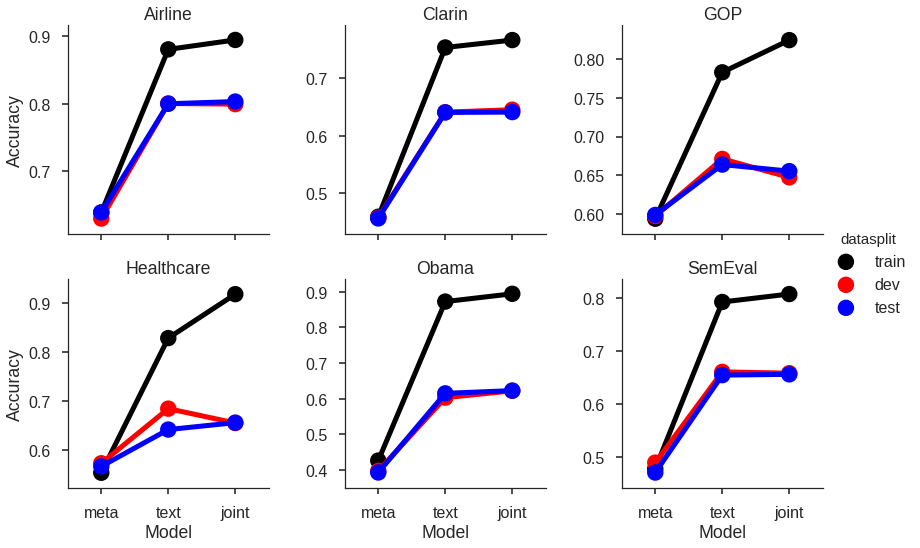

In [102]:
plot_scores(df_scores, y="accuracy", label="Accuracy")

## Final overall model

In [91]:
%%time

feature_map = {
        "text": [('text', [TfidfVectorizer(tokenizer=process_tweets),
                           #StandardScaler(with_mean=False)
                          ]),],
        "user": [
            (['u_statuses', 'u_statuses_2',
              'u_followers', 'u_followers_2',
              'u_friends', 'u_friends_2',
              'user_age', 
             ], StandardScaler()),
           ('u_verified', None),
           ('u_has_url', None),
        ],
        "tweet": [
            (['n_urls', 'n_hashtags', 'n_mentions'], StandardScaler()),
            (['is_reply', 'is_quote'], None)
        ]
    }


model_meta_features = feature_map["user"] + feature_map["tweet"]
model_text_features = feature_map["text"]

scores = []
models = []

df_processed = df[(df.language == "english")].copy()

class InteractionJointModels(RunModels):
    def get_joint_X(self, df_sample):
        X = pd.DataFrame(
            data=np.hstack([self.meta_model.predict_proba(df_sample.copy()),
                            self.text_model.predict_proba(df_sample.copy())]),
            columns=(self.meta_cols + self.text_cols)
        )
        joint_formula = "(%s)*(%s)" % ("+".join(self.meta_cols), "+".join(self.text_cols))
        X = patsy.dmatrix(joint_formula, X, return_type="dataframe")
        return X


def run_experiment(df_processed, dataset):
    df_t = df_processed
    if dataset != "overall":
        df_t = df_t[df_t.dataset==dataset]
    print "Dataset: %s" % dataset
    print df_t.shape
    df_t = df_t.copy().assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "user_age": lambda x: np.log10(x["user_age"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
        }).assign(**{
            "u_statuses_2": lambda x: (x["u_statuses"]**2),
            "u_followers_2": lambda x: (x["u_followers"]**2),
            "u_friends_2": lambda x: (x["u_friends"]**2),
        })

    experiment = InteractionJointModels(
        df_t, model_meta_features, model_text_features,
        scoring, dataset,
    )
        
    experiment.train_all_models()
    return experiment.scores, experiment.models, dataset, experiment.joint_cols
    
scores, models, datasets, joint_cols = zip(
    *Parallel(n_jobs=1, verbose=10)(
        delayed(run_experiment)(df_processed, dataset)
        for dataset in ["overall"]
    )
)

Dataset: overall
(128625, 28)
Prepared datasets
Done text model
Done meta model
Done joint model
CPU times: user 3min 37s, sys: 3.66 s, total: 3min 41s
Wall time: 3min 37s


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


In [92]:
df_scores = get_scores_df(scores)
df_scores

,dataset,model,datasplit,precision,recall,f1,support,kld_pcc,kld_cc,accuracy
0,overall,text,train,0.746456,0.729131,0.734918,None,9.970192e-05,0.008122,0.735800
1,overall,text,dev,0.668231,0.655479,0.660186,None,1.008786e-04,0.005318,0.660352
2,overall,text,test,0.663131,0.649487,0.654235,None,1.170776e-06,0.006629,0.654967
3,overall,meta,train,0.408178,0.399272,0.374042,None,2.313077e-11,0.177392,0.428848
4,overall,meta,dev,0.414991,0.403921,0.378790,None,1.940839e-06,0.179647,0.433207
5,overall,meta,test,0.410542,0.401391,0.376191,None,3.813983e-06,0.176792,0.430854
6,overall,joint,train,0.746442,0.736917,0.740620,None,1.048684e-08,0.002994,0.740562
7,overall,joint,dev,0.667511,0.661361,0.663993,None,4.288720e-04,0.001378,0.662878
8,overall,joint,test,0.661863,0.654589,0.657539,None,9.598170e-05,0.002210,0.657105


In [93]:
for i, score_label in enumerate(
    ["accuracy", "precision", "recall", "f1", "kld_cc"]):
    print score_label
    df_t = df_scores.pivot(
        index="datasplit", columns="model",
        values=score_label)[["meta", "text", "joint"]]
    display(df_t)

accuracy


model,meta,text,joint
datasplit,,,
dev,0.433207,0.660352,0.662878
test,0.430854,0.654967,0.657105
train,0.428848,0.735800,0.740562


precision


model,meta,text,joint
datasplit,,,
dev,0.414991,0.668231,0.667511
test,0.410542,0.663131,0.661863
train,0.408178,0.746456,0.746442


recall


model,meta,text,joint
datasplit,,,
dev,0.403921,0.655479,0.661361
test,0.401391,0.649487,0.654589
train,0.399272,0.729131,0.736917


f1


model,meta,text,joint
datasplit,,,
dev,0.378790,0.660186,0.663993
test,0.376191,0.654235,0.657539
train,0.374042,0.734918,0.740620


kld_cc


model,meta,text,joint
datasplit,,,
dev,0.179647,0.005318,0.001378
test,0.176792,0.006629,0.002210
train,0.177392,0.008122,0.002994


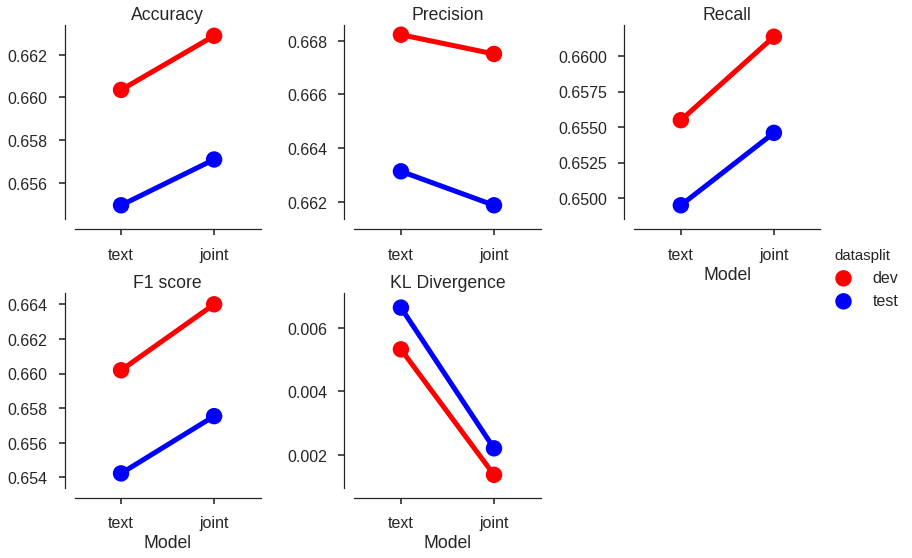

In [94]:

df_t = pd.melt(df_scores.drop(
    ["dataset", "support", "kld_pcc"],
    axis=1
).rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "accuracy": "Accuracy",
    "f1": "F1 score",
    "kld_cc": "KL Divergence"}),
        id_vars=["model", "datasplit"],)

g = sns.factorplot(x="model", y="value",
                   hue="datasplit",
                   hue_order=["dev", "test"],
                   col="variable",
                    order = ["text", "joint"],
                   col_wrap=3,
                    sharey=False,
                   col_order=["Accuracy", "Precision",
                              "Recall", "F1 score",
                              "KL Divergence"
                             ],
                   palette=sns.color_palette(["r", "b"]),
                   lw=0.5, ms=2,
                   facet_kws={"legend_out": False},
        data=df_t
    )
    #model != 'meta' and 

(g.set_axis_labels("Model", "")
 .set_titles("{col_name}")
 .despine(offset=10)
)

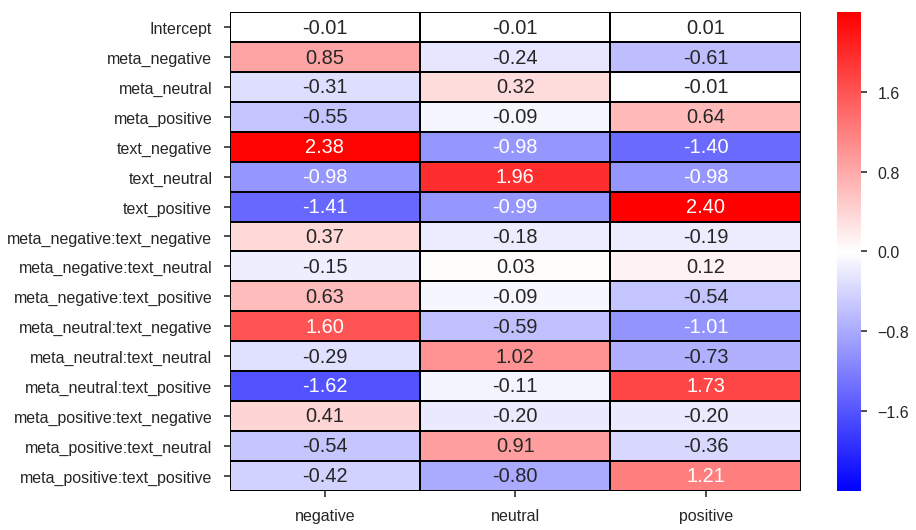

In [95]:
df_models = get_models_df(models)
clf = df_models[("overall", "joint")]

sns.heatmap(pd.DataFrame(clf.coef_,
                         columns=dict(zip(datasets, joint_cols))["overall"],
                         index=clf.classes_).T,
           cmap="bwr", annot=True, fmt=".2f",
            linewidths=1,
            linecolor="k",
            #square=True,
            annot_kws={
               "fontsize": 20
           })